In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler,normalize

In [11]:
source = "../data_source/present_data.csv"

In [12]:
dataf = pd.read_csv(source)

In [13]:
f_dataf = dataf.dropna()
f_dataf.shape

(1912, 13)

In [14]:
pars = list(f_dataf.columns)
print(pars)

['Unnamed: 0', 'latitude', 'longitude', 't_winter', 't_spring', 't_summer', 't_fall', 'p_winter', 'p_spring', 'p_summer', 'p_fall', 'carb', 'veg']


(1912, 2)
Clustering completed after 19 iterations


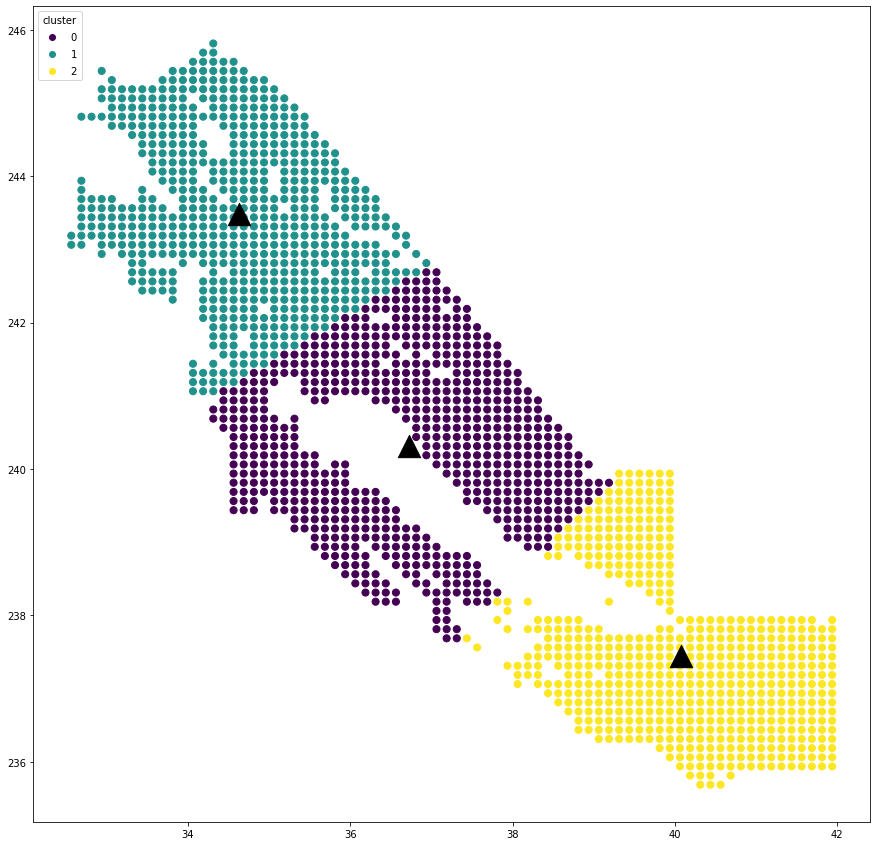

In [15]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

class ClusterGenerator:
    def __init__(self, moduelNum, dataSource="../data_source/present_data.csv"):
        self.num = moduelNum
        self.source = dataSource
        self.classifications = None
        self.centers = None
        self.oriData = None
        self.clusterData = None

    def dataMap(self):
        None

    def loadData(self):
        dataf = pd.read_csv(self.source)
        f_dataf = dataf.dropna()
        self.oriData = f_dataf
        self.clusterData = self.oriData.copy()
        data_np = f_dataf.to_numpy(dtype="float32")
        self.data = data_np[:,1:3]
        print(self.data.shape)

    def showGrid(self):
        plt.figure(figsize=(15, 15))
        scatter1 = plt.scatter(x=self.data[:, 0], y=self.data[:, 1], s=50, c=self.classifications)
        scatter2 = plt.scatter(x=self.centers[:, 0], y=self.centers[:, 1], s=500, c='k', marker='^')
        plt.legend(*scatter1.legend_elements(),
                    loc="upper left", title="cluster")
    
    def kmeans(self, normalize=False, limit=200):

        """Basic k-means clustering algorithm.
        """
        # optionally normalize the data. k-means will perform poorly or strangely if the dimensions
        # don't have the same ranges.

        data = self.data
        k = self.num

        if normalize:
            stats = (data.mean(axis=0), data.std(axis=0))
            data = (data - stats[0]) / stats[1]
        
        # pick the first k points to be the centers. this also ensures that each group has at least
        # one point.
        centers = data[:k]

        for i in range(limit):
            # core of clustering algorithm...
            # first, use broadcasting to calculate the distance from each point to each center, then
            # classify based on the minimum distance.
            classifications = np.argmin(((data[:, :, None] - centers.T[None, :, :])**2).sum(axis=1), axis=1)
            # next, calculate the new centers for each cluster.
            new_centers = np.array([data[classifications == j, :].mean(axis=0) for j in range(k)])

            # if the centers aren't moving anymore it is time to stop.
            if (new_centers == centers).all():
                break
            else:
                centers = new_centers
        else:
            # this will not execute if the for loop exits on a break.
            raise RuntimeError(f"Clustering algorithm did not complete within {limit} iterations")
                
        # if data was normalized, the cluster group centers are no longer scaled the same way the original
        # data is scaled.
        # if normalize:
        #     centers = centers * stats[1] + stats[0]

        print(f"Clustering completed after {i} iterations")

        self.classifications = classifications
        self.centers = centers
        self.clusterData['cluster'] = classifications
    
cg = ClusterGenerator(3)
cg.loadData()
cg.kmeans()
cg.showGrid()


# %matplotlib inline



In [29]:
from sklearn.preprocessing import StandardScaler, normalize
from torch import nn

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

    def __len__(self):
        return self.length

class Net(nn.Module):

    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        # self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(32,1)
        # self.y_class = nn.Linear(32,1)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.sigmoid(self.fc3(x))
        x = self.fc3(x)
        x = torch.sigmoid(x)

        return x

SPLIT_THRES = 0.7

data_np = cg.clusterData.to_numpy(dtype="float32")
print(data_np.shape)
net_list = []
for idx in range(cg.centers.shape[0]):
    cls_data = data_np[data_np[:,-1]==idx] #Filtered by cluster
    np.random.shuffle(cls_data)
    x_full = cls_data[:, 3:-3]
    y_full = cls_data[:, -2]
    

    split_indx = int(x_full.shape[0]*SPLIT_THRES)
    x_train = x_full[:split_indx]
    y_train = y_full[:split_indx]
    x_val = x_full[split_indx:]
    y_val = y_full[split_indx:]

    print(x_train.shape,x_val.shape)

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_val = sc.transform(x_val)
    print(type(x_train),type(x_val))
    y_train = (y_train-min(y_train))/(max(y_train)-min(y_train))
    y_val = (y_val-min(y_val))/(max(y_val)-min(y_val))
#     y_train = normalize(y_train.reshape(-1, 1))
#     y_val = normalize(y_val.reshape(-1, 1))

    train_dataset = dataset(x_train, y_train)
    val_dataset = dataset(x_val, y_val)

    trainloader = DataLoader(train_dataset,batch_size=16,shuffle=True)
    valloader = DataLoader(val_dataset,batch_size=16,shuffle=False)
    print(len(train_dataset))


    net = Net(x_full.shape[1])
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
    class_loss_func = torch.nn.BCELoss()  # the target label is NOT an one-hotted

    

    # print(net)
    train_losses = []
    train_accur = []
    val_losses = []
    val_accur = []
    for i in range(200):
        for j,(x,y) in enumerate(trainloader):
            #calculate output
            output = net(x)
        
            #calculate loss
            train_loss = class_loss_func(output,y.reshape(-1,1))
        
            # loss = reg_loss_func(output,y )
        
            #class accuracy
            
            predicted = net(torch.tensor(x_train, dtype=torch.float32))
            train_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

            #backprop


        for j_v,(x_v,y_v) in enumerate(valloader):

            val_output = net(x_v)

            #calculate loss
            val_loss = class_loss_func(val_output,y_v.reshape(-1,1))

            #class accuracy

            predicted = net(torch.tensor(x_val, dtype=torch.float32))
            val_acc = (predicted.reshape(-1).detach().numpy().round() == y_val).mean()

        if i%20 == 0:
            train_losses.append(train_loss.data)
            train_accur.append(train_acc)
            val_losses.append(val_loss.data)
            val_accur.append(val_acc)
            # print("Net: {} epoch: {:<5} train_loss:{:5f} train_accuracy:{:5f}".format(idx, i,train_loss,train_acc))
                # val_losses.append(val_loss.data)
                # val_accur.append(val_acc)
            print("epoch {:<5} train_loss:{:.5f} val_loss: {:.5f} train_accuracy:{:.5f} val_accuracy: {:.5f}".format(i,train_loss,val_loss,train_acc,val_acc))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    net_list.append([net,[train_losses,train_accur]])


(1912, 14)
(482, 8) (207, 8)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
482
epoch 0     train_loss:0.99308 val_loss: 0.67770 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 20    train_loss:0.58691 val_loss: 0.67116 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 40    train_loss:0.72347 val_loss: 0.66490 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 60    train_loss:0.52443 val_loss: 0.65981 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 80    train_loss:0.70624 val_loss: 0.65415 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 100   train_loss:0.73192 val_loss: 0.65006 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 120   train_loss:0.67881 val_loss: 0.64368 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 140   train_loss:0.87004 val_loss: 0.63860 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 160   train_loss:1.07206 val_loss: 0.63319 train_accuracy:0.76349 val_accuracy: 0.83575
epoch 180   train_loss:0.51435 val_loss: 0.62844 train_accuracy:0.76349 v

In [22]:
yt = y_val = (y_val-min(y_val))/(max(y_val)-min(y_val))

In [23]:
yt

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1.], dtype=float32)

In [ ]:

data_np = f_dataf.to_numpy(dtype="float32")
x_train = data_np[:1600,3:-2]
x_val = data_np[1600:,3:-2]

##### Specify the label category -1 for veg classification and -2 for carb regression
y_train = data_np[:1600,-1]
y_val = data_np[1600:,-1]

## Normalize the input data
# sc = StandardScaler()
sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
# y_train = (y_train-min(y_train))/(max(y_train)-min(y_train)) 

x_val = sc.fit_transform(x_val)
# y_val = (y_val-min(y_val))/(max(y_val)-min(y_val))


print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return self.length

trainset = dataset(x_train,y_train)
valset = dataset(x_val,y_val)
#DataLoader
trainloader = DataLoader(trainset,batch_size=16,shuffle=True)
valloader = DataLoader(valset,batch_size=16,shuffle=False)





In [139]:
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(nn.Module):

  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    # self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(32,1)
    # self.y_class = nn.Linear(32,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    # x = torch.relu(self.fc2(x))
    # x = torch.sigmoid(self.fc3(x))
    x = self.fc3(x)
    x = torch.sigmoid(x)
   
    return x


net = Net(x.shape[1])     # define the network
# if torch.cuda.is_available():
#     print("using Gpu")
#     net = net.cuda()
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.005)
reg_loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
class_loss_func = torch.nn.BCELoss()  # the target label is NOT an one-hotted



Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (y_class): Linear(in_features=32, out_features=1, bias=True)
)


In [140]:
train_losses = []
train_accur = []
val_losses = []
val_accur = []

for i in range(600):
  for j,(x,y) in enumerate(trainloader):
    
    #calculate output
    output = net(x)
 
    #calculate loss
    train_loss = class_loss_func(output,y.reshape(-1,1))
 
    # loss = reg_loss_func(output,y )
 
    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    train_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()

    #backprop
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  for j,(x,y) in enumerate(valloader):

    val_output = net(x)
 
    #calculate loss
    val_loss = class_loss_func(val_output,y.reshape(-1,1))

    #class accuracy
    
    predicted = net(torch.tensor(x_train, dtype=torch.float32))
    val_acc = (predicted.reshape(-1).detach().numpy().round() == y_train).mean()


  if i%10 == 0:
    train_losses.append(train_loss.data)
    train_accur.append(train_acc)
    val_losses.append(val_loss.data)
    val_accur.append(val_acc)
    print("epoch {:<5} train_loss:{:5f} val_loss: {:5f} train_accuracy:{:5f} val_accuracy: {:5f}".format(i,train_loss,val_loss,train_acc,val_acc))

epoch 0     train_loss:0.502335 val_loss: 0.696936 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 10    train_loss:0.375040 val_loss: 0.810014 train_accuracy:0.821250 val_accuracy: 0.821250
epoch 20    train_loss:0.294125 val_loss: 0.788576 train_accuracy:0.815625 val_accuracy: 0.815000
epoch 30    train_loss:0.400264 val_loss: 0.790851 train_accuracy:0.849375 val_accuracy: 0.849375
epoch 40    train_loss:0.428806 val_loss: 0.823503 train_accuracy:0.865000 val_accuracy: 0.865625
epoch 50    train_loss:0.188325 val_loss: 0.873799 train_accuracy:0.876250 val_accuracy: 0.876250
epoch 60    train_loss:0.208706 val_loss: 0.928171 train_accuracy:0.878750 val_accuracy: 0.878750
epoch 70    train_loss:0.407459 val_loss: 0.987290 train_accuracy:0.883125 val_accuracy: 0.883125
epoch 80    train_loss:0.269072 val_loss: 1.042308 train_accuracy:0.883750 val_accuracy: 0.883125
epoch 90    train_loss:0.284591 val_loss: 1.099210 train_accuracy:0.883750 val_accuracy: 0.883750
epoch 100   train_lo

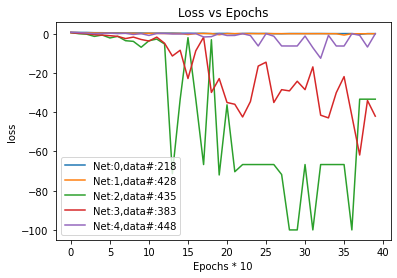

In [46]:

for i in range(len(net_list)):
    train_losses = net_list[i][1][0]
    plt.plot(train_losses,label="Net:{},data#:{}".format(i,data_np[data_np[:,-1]==i].shape[0]))
    # plt.plot(val_losses,label='val')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs * 10')
    plt.ylabel('loss')
    plt.legend()

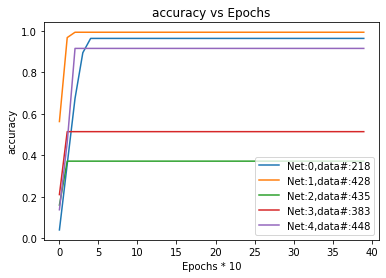

In [47]:
for i in range(len(net_list)):
    train_accur = net_list[i][1][1]
    plt.plot(train_accur,label="Net:{},data#:{}".format(i,data_np[data_np[:,-1]==i].shape[0]))
    # plt.plot(val_losses,label='val')
    plt.title('accuracy vs Epochs')
    plt.xlabel('Epochs * 10')
    plt.ylabel('accuracy')
    plt.legend()

IndexError: index 1 is out of bounds for dimension 1 with size 1

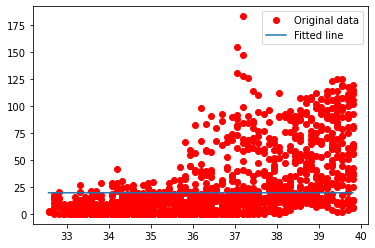

In [30]:
predicted = net(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train[:,0], y_train, 'ro', label='Original data')
plt.plot(x_train[:,0], predicted, label='Fitted line')
plt.legend()
plt.show()

(1600, 8) (1600, 1) (1600, 1)
Net(
  (hidden): Linear(in_features=8, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (predict_class): Linear(in_features=32, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predict_reg): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
x:torch.Size([1600, 8]) y1:torch.Size([1600, 1]) y2:torch.Size([1600, 1])y1_train:(1600, 1)y2_train(1600, 1)
tensor(0.7489, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.4648, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1769, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.1678, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-0.5984, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-1.1760, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-2.0008, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(-3

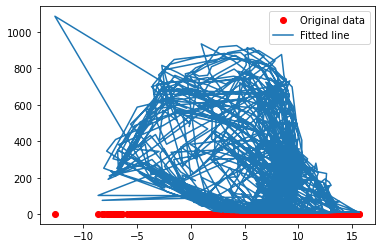

(-15.0, 15.0)

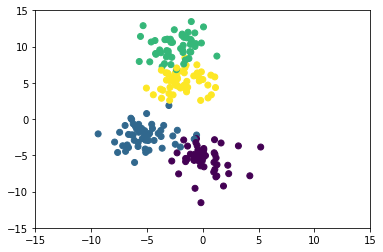

In [148]:
# import statements
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points
points = data[0]
# create scatter plot
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)

In [18]:
cg.clusterData[cg.clusterData['cluster'] == 0]

,Unnamed: 0,latitude,longitude,t_winter,t_spring,t_summer,t_fall,p_winter,p_spring,p_summer,p_fall,carb,veg,cluster
265,265,34.3125,240.6875,12.673417,15.279175,20.107550,17.995707,2.738192,0.956680,0.038420,0.708766,10.207090,1.0,0
266,266,34.3125,240.8125,12.915713,15.333584,19.770353,17.944431,2.632629,0.929270,0.039727,0.703246,6.834608,1.0,0
306,306,34.4375,240.5625,9.984474,12.831476,17.848717,15.537080,4.090013,1.445341,0.045205,0.981243,24.921393,2.0,0
307,307,34.4375,240.6875,11.274170,14.624917,20.577286,17.466093,3.240951,1.167551,0.044709,0.811583,18.621461,1.0,0
308,308,34.4375,240.8125,10.430933,13.923525,20.111055,16.794477,3.443468,1.199076,0.044417,0.892705,17.383121,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,1088,36.9375,239.0625,8.681682,16.117730,24.607367,18.001232,1.276815,0.508271,0.034925,0.438944,0.989707,1.0,0
1089,1089,36.9375,240.1875,9.623520,16.959682,26.844252,19.182852,1.737739,0.933559,0.068731,0.590391,9.173672,1.0,0
1090,1090,36.9375,240.3125,9.452579,16.558691,26.605762,19.035355,1.954302,1.006050,0.066783,0.638782,11.409437,1.0,0
1091,1091,36.9375,240.4375,9.719103,16.590399,26.925142,19.254158,2.379324,1.172087,0.087602,0.728828,11.528240,1.0,0
